In [1]:
import torch
from torch import nn as nn
from torch.distributions import Normal, multivariate_normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.autograd import Variable
import collections
from typing import Iterable
import scipy.sparse as sp_sparse
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from tqdm import trange
from tqdm import tqdm
import sys

import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scanpy as sc
from Generate_data import *
from tensorboardX import SummaryWriter
writer = SummaryWriter('log')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 20
epochs = 30
X_dim = 20
n_sample = 2000

In [5]:
class Dataset_Sim(Dataset):
    def __init__(self, Expression_Matrix):
        """
        :param Expression_Matrix: a numpy array save the expression matrix
        """
        self.Expression_Matrix = Expression_Matrix

    def __len__(self):
        return self.Expression_Matrix.shape[0]

    def __getitem__(self, item):
        return self.Expression_Matrix[item]

In [6]:
class VAE(nn.Module):
    def __init__(self, input_size=10, h_dim=100, z_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size(), device = device)
       
        z = mu + std * esp
#         print('mu = ', mu)
#         print('logvar =  ', logvar)
#         print('esp = ', esp)
#         print('std = ', std)
#         print('z = ', z)
        return z
    def encoder_function(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
        
    def forward(self, x):
        mu, logvar = self.encoder_function(x)
        z = self.reparameterize(mu, logvar)
#         print(z)
#         print(self.decoder(z))
        return self.decoder(z), mu, logvar

In [7]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [8]:
vae = VAE(input_size=X_dim)
# if torch.cuda.is_available():
#     vae.cuda()
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [21]:
sim1 = Generate_X(X_dim)
sim1.generate([3,5],[n_sample, n_sample], same_mean = False, same_sigma = False)
#print(sample_indices)
sample_size = np.repeat(2*n_sample,1)
sample_indices = sim_sample_indices(sample_size)

In [11]:
sim1.X = (sim1.X - np.average(sim1.X)) / np.std(sim1.X)

In [12]:
data_loader = torch.utils.data.DataLoader(Dataset_Sim(sim1.X), batch_size=10, shuffle=True, )

In [13]:
for epoch in range(epochs):
    for idx, X in enumerate(data_loader):
        X = X.to(device)
        X = X.float()
        recon_X, mu, logvar = vae(X)
        loss = loss_fn(recon_X, X, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/batch_size))

Epoch[1/100] Loss: -89.430
Epoch[2/100] Loss: -66.371
Epoch[3/100] Loss: -202.504
Epoch[4/100] Loss: -94.370
Epoch[5/100] Loss: -90.705
Epoch[6/100] Loss: -49.956
Epoch[7/100] Loss: -70.276
Epoch[8/100] Loss: -99.577
Epoch[9/100] Loss: -123.100
Epoch[10/100] Loss: -160.122
Epoch[11/100] Loss: -53.336
Epoch[12/100] Loss: -81.632
Epoch[13/100] Loss: -94.875
Epoch[14/100] Loss: -139.225
Epoch[15/100] Loss: -78.171
Epoch[16/100] Loss: -72.037
Epoch[17/100] Loss: -63.822
Epoch[18/100] Loss: -91.173
Epoch[19/100] Loss: -110.314
Epoch[20/100] Loss: -104.352
Epoch[21/100] Loss: -123.925
Epoch[22/100] Loss: -79.476
Epoch[23/100] Loss: -60.762
Epoch[24/100] Loss: -109.573
Epoch[25/100] Loss: -82.990
Epoch[26/100] Loss: -145.802
Epoch[27/100] Loss: -141.041
Epoch[28/100] Loss: -123.162
Epoch[29/100] Loss: -118.865
Epoch[30/100] Loss: -80.495
Epoch[31/100] Loss: -129.965
Epoch[32/100] Loss: -120.816
Epoch[33/100] Loss: -133.186
Epoch[34/100] Loss: -95.130
Epoch[35/100] Loss: -81.847
Epoch[36/100] 

In [14]:
trainloader_new = torch.utils.data.DataLoader(Dataset_Sim(sim1.X), batch_size=4000, shuffle=False)
dataiter = iter(trainloader_new)
X = dataiter.next()
X = X.float()
X = X.to(device)

In [15]:
mean, logvar  = vae.encoder_function(X)
z = vae.reparameterize(mean, logvar)
x_new = vae.decoder(z)

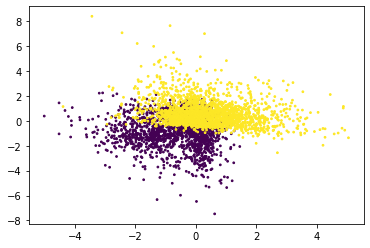

In [16]:
plt.scatter(z[:,0].cpu().detach().numpy(), z[:,1].cpu().detach().numpy(), c = sim1.ct_label[0:4000], s = [3]*len(z))
# plt.savefig('./figures/vae.7242019.3000.png')

In [17]:
np.savetxt('./write/simulation', sim1.X, delimiter = ',')

In [18]:
adata = sc.read_csv('./write/simulation')

In [22]:
adata.obs['cell type'] = sim1.ct_label
adata.obs['batch'] = sample_indices

In [23]:
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'euclidean', random_state = None)
sc.tl.umap(adata, min_dist = 0.1)

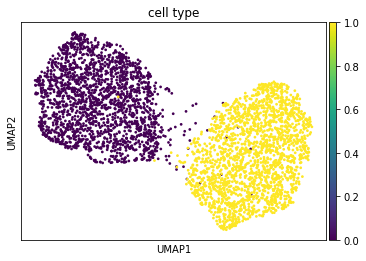

In [24]:
sc.pl.umap(adata, color = 'cell type')

In [25]:
sc.tl.pca(adata)

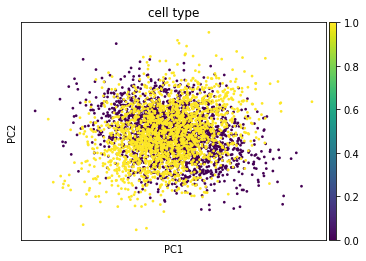

In [26]:
sc.pl.pca(adata, color = 'cell type')

In [27]:
sc.tl.tsne(adata)

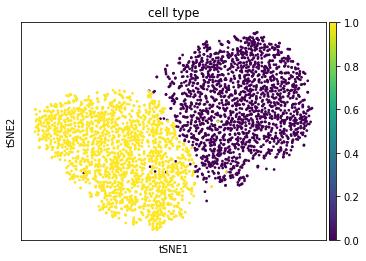

In [28]:
sc.pl.tsne(adata, color = 'cell type')